In [169]:
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.fftpack import fft,fftshift
from math import pi

## Generate an LFM signal

In [170]:
# | export

def complex_oscillator_lfm(
    z: torch.ComplexType,
    initial_phase: torch.ComplexType = None,
    N: int = 2048,
    constrain: bool = False,
    reduce: bool = False,
):
    """Generates an exponentially decaying sinusoid from a complex number."""

    if initial_phase is None:
        # If no initial phase is provided, use zero phase.
        # Note that in the complex representation, zero phase is equivalent to a real number.
        initial_phase = torch.ones_like(z)
    
    if constrain:
        # Limit the magnitude of z to 1. Note that tanh is used in lieu of sigmoid to 
        # avoid vanishing gradients as magnitude approaches zero.
        mag = torch.abs(z)
        z = z * torch.tanh(mag) / mag
    
    z = z[..., None].expand(*z.shape, N - 1)
    z = torch.cat([initial_phase.unsqueeze(-1), z], dim=-1)
    
    y = z ** (torch.arange(0,N,1) ** 2)

    if reduce:
        y = y.sum(dim=-2)

    return y

def mseloss(predicted_signal,target_signal):
    criterion = torch.nn.MSELoss()
    loss = criterion(torch.real(predicted_signal), torch.real(target_signal)) + criterion(torch.imag(predicted_signal), torch.imag(target_signal))-1
    return loss

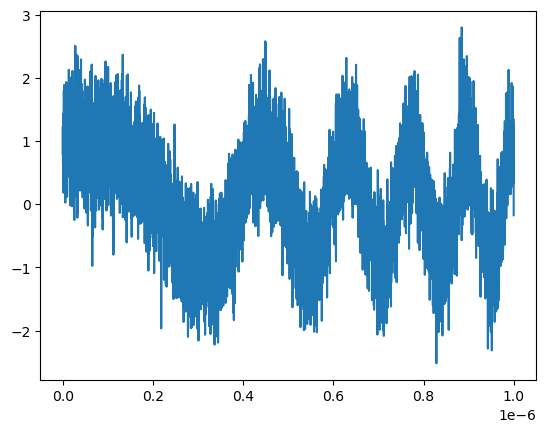

In [171]:
Fs = 6400e6
pw = 1e-6
bw = 10e6
sig = 1

t = torch.arange(0,pw,1/Fs)
x = torch.exp(1j*pi*bw/pw*t**2)+sig**2/2*torch.randn(t.shape)
N = x.shape[0]

plt.plot(t,x)
plt.show()

In [172]:
maxbw = 200e6
kscale = pi*maxbw/(pw*Fs**2)
starting_chirprate = torch.tensor([0.04])#torch.rand(1) * math.pi

predicted_z = torch.exp(1j * kscale * starting_chirprate)


predicted_signal = complex_oscillator_lfm(predicted_z, N=N, reduce=True).squeeze()


target_signal = x

predicted_z.detach_().requires_grad_(True)

numiter = 10000
criterion = torch.nn.MSELoss()
optimiser = torch.optim.SGD([predicted_z], lr=1e-7)
z_hist = torch.complex(torch.zeros(numiter,1),torch.zeros(numiter,1))


print(f"Starting bandwidth: {(starting_chirprate*maxbw).item()}")

for step in range(numiter):
    z_hist[step] = predicted_z
    predicted_signal = complex_oscillator_lfm(predicted_z, N=N, reduce=True).squeeze()
    loss = mseloss(predicted_signal,target_signal)
    optimiser.zero_grad()
    loss.backward()
    predicted_z.grad = predicted_z.grad / predicted_z.grad.abs()
    optimiser.step()

    if (step + 1) % 1000 == 0:
        print(f"--- Step: {step + 1} ---")
        print(f"Predicted bandwidth: {predicted_z.angle().abs().item()*pw*(Fs**2)/pi}")
        print(f"Target bandwidth: {bw}")


Starting bandwidth: 8000000.0
--- Step: 1000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 2000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 3000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 4000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 5000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 6000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 7000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 8000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 9000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0
--- Step: 10000 ---
Predicted bandwidth: 10534763.41745948
Target bandwidth: 10000000.0


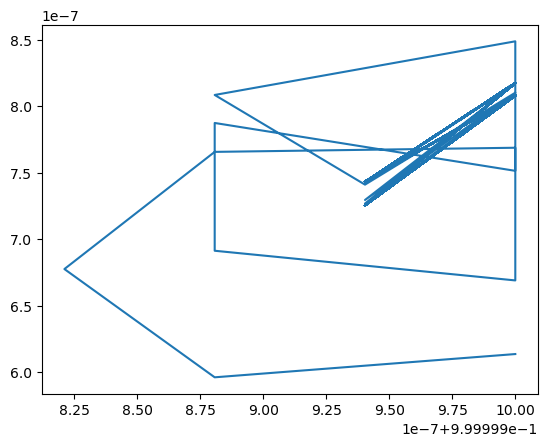

tensor([0.9992+0.0400j])
tensor([1.+8.0801e-07j], requires_grad=True)


In [173]:
plt.plot(torch.real(z_hist).detach().numpy(),torch.imag(z_hist).detach().numpy())
plt.show()

print(torch.exp(1j * starting_chirprate))
print(predicted_z)

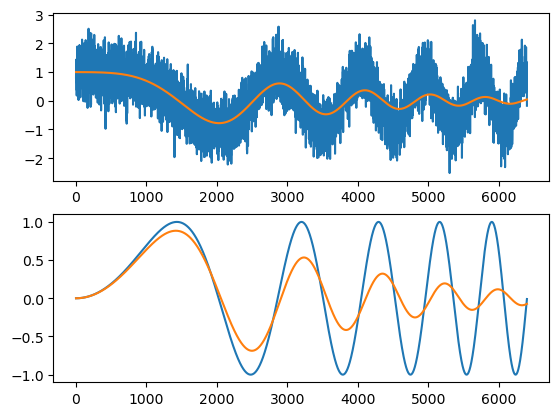

In [174]:
plt.figure()

plt.subplot(2,1,1)
plt.plot(torch.real(target_signal))
plt.plot(torch.real(predicted_signal).detach().numpy())

plt.subplot(2,1,2)
plt.plot(torch.imag(target_signal))
plt.plot(torch.imag(predicted_signal).detach().numpy())

plt.show()